# Forward model corner plot

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob as glob
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns

import corner
import json
import pathlib
import pickle
import utils
import warnings
import itertools

from astropy import constants as const
from astropy import units as uni
from astropy.io import ascii, fits
from astropy.time import Time
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.interpolate import griddata

# Default figure dimensions
FIG_WIDE = (11, 5)
FIG_LARGE = (8, 11)
FIG_SQUARE = (10, 10)

# Figure style
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = utils.plot_params()
plt.rcParams.update(params)

## Load

In [3]:
base_dir = "data/tspec_forward_model_corner"
target = "HAT-P-23"
data_dict = {
    # Matrix of chisq values: N_models x N_iterations?
    "chisq": np.loadtxt(f"{base_dir}/{target}_iso_chi_square_local_GAIA_DR2.out", delimiter=','),
    #"offset":      np.loadtxt(f"{base_dir}/{target}_iso_offsetarray_local_GAIA_DR2.out", delimiter=','),
    # Corresponding matrix of parameter values: N_models x N_params
    "model_params":  np.genfromtxt(
        f"{base_dir}/{target}_iso_model_name_local_GAIA_DR2.out",
        delimiter = '_',
        usecols = range(1, 7),
        names = ["Temperature", "Gravity", "Metallicity", r"C/O-ratio", "Haze", "Clouds"],
        deletechars='',
    ),
}

# Get min chisq 
# Model Parameters: (temp, gravity, metal, co, haze, cloud)
chi_squared_stat3 = data_dict["chisq"]
min_chi3 = np.min(chi_squared_stat3)
min_coords = np.argwhere(chi_squared_stat3 == min_chi3)[0]
min_index_chi3 = min_coords[0]
min_index_chi3_offset = min_coords[1]
model_params = data_dict["model_params"]
min_model_params = model_params[min_index_chi3]

## Compute

In [4]:
# Returns `mapname`, where `mapname` is an N_matches x 3 array.
# The first column is the matching `param_x`, second is the matching `param_y`
# and the third column is the associated chisq (`chi2`)
def match_params(
    params_ranges,
    variablex,
    variabley,
    i,
    j,
    params=model_params,
    chi_vals=chi_squared_stat3,
    min_chi=min_chi3,
):
    # Select parameter pair to search for
    param_val_1, param_val_2 = param_ranges[variablex][i], param_ranges[variabley][j]
    
    # Match to chi_squared array
    #print(f"Trying match for ({variablex}, {variabley}) at ({param_val_1}, {param_val_2})")
    #print(params[variablex], params[variabley])
    params_match = np.where((params[variablex] == param_val_1) & (params[variabley] == param_val_2))[0]
    
    if params_match.size == 0:
        #print("No match\n")
        return -1

    # Compute 
    chi1 = np.min(chi_vals[params_match], axis=1)
    chi2 = np.min(chi1) - min_chi3
    mapname = [param_val_1, param_val_2, chi2]
    #print("Match!\n")
    return mapname

In [5]:
#############################
# Match param values to chisq
#############################
param_ranges = {
    "Temperature": np.arange(400, 2700, 100.0),
    "Gravity": np.array([20, 50.0]),
    "Metallicity": np.array([-1, 0, 1, 1.7, 2, 2.3]),
    "C/O-ratio": np.array([0.35, 0.56, 0.70, 1]),
    "Haze": np.array([1, 10, 150, 1100.0]) ,
    "Clouds": np.array([0, 0.06, 0.2, 1]), # Cloud bottom
}
map_dict = {}
for param_x, param_y in itertools.combinations(param_ranges.items(), 2):
    param_x_name, param_y_name = param_x[0], param_y[0]
    param_x_length, param_y_length = len(param_x[1]), len(param_y[1])
    map_vals = np.array([
        match_params(param_ranges, param_x_name, param_y_name, i, j)
        for i in range(param_x_length) for j in range(param_y_length)
    ])
    
    map_dict[f"{param_x_name}_{param_y_name}"] = map_vals

# Switching to row-major for plotting later, because Python
param_ys = [
    "_Gravity",
    "_Metallicity",
    "_C/O-ratio",
    "_Haze",
    "_Clouds",
]
map_dict_RM = {}
for param_y in param_ys:
    for k in map_dict.keys():
        if param_y in k:
            map_dict_RM[k] = map_dict[k]

## Plot

In [6]:
def plot_contour_map(ax, mapname, **kwargs):
    map_variable_x = mapname[:, 0]
    map_variable_y = mapname[:, 1]
    xi = np.linspace(min(map_variable_x), max(map_variable_x), 100)
    yi = np.linspace(min(map_variable_y), max(map_variable_y), 100)

    Z_interp = griddata(
        (map_variable_x, map_variable_y),
        mapname[:, 2],
        (xi[None, :], yi[:, None]),
    )

    p = ax.contourf(xi, yi, Z_interp, levels, **kwargs)
    
    return p

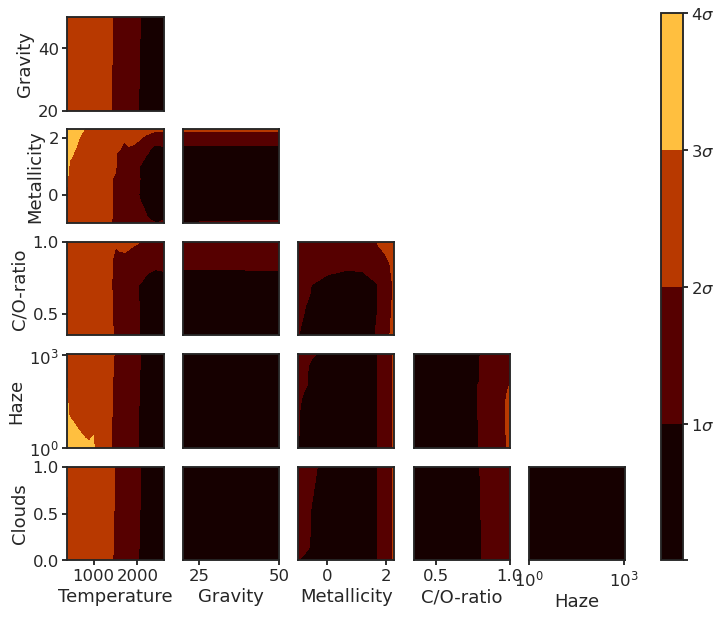

In [7]:
fig, axes = plt.subplots(5, 5, figsize=FIG_SQUARE)

# Contour plot settings
cmap = "afmhot"
# How many free parameters were used to calculate these intervals from the big chisquare table
levels = [
        0,
        2.30,
        6.18,
        11.83,
        19.33,
]
vmin, vmax = 0, 25

# Delete upper triangle of subplots
[fig.delaxes(axes[i, j]) for i in range(5) for j in range(i, 5) if i != j]

# Plot contours
for ax, (pair_name, mapdata) in zip(fig.axes, map_dict_RM.items()):
    line2 = plot_contour_map(ax, mapdata, cmap=cmap, levels=levels, vmin=vmin, vmax=vmax)
    name_x, name_y = pair_name.split('_')
    ax.set_xlabel(name_x)
    ax.set_ylabel(name_y)
    
    if name_x == "Haze": ax.set_xscale("log")
    if name_y == "Haze": ax.set_yscale("log")
    #if name_x == "Metallicity":ax.set_xscale("symlog")
    
    
# Apply specific axis settings
for ax in fig.axes:
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
[ax.axes.yaxis.set_visible(True) for ax in axes[:, 0]]
[ax.axes.xaxis.set_visible(True) for ax in axes[-1, :]]

cbar_ax = fig.add_axes([0.95, 0.125, 0.03, 0.76])
cbar = fig.colorbar(line2, cax=cbar_ax)
cbar.set_ticklabels(
    ["", r"$1 \sigma$", r"$2 \sigma$", r"$3 \sigma$", r"$4 \sigma$"],
    update_ticks=True,
)

fig.set_size_inches(FIG_SQUARE)